# DL 01.01 Линейная регрессия

Предположим вы выбираете автомобиль, но вы абсолютно в них не разбираетесь и хотите узнать какая цена была бы аккутуальной для той или иной модели. У нас есть файл в котором храняться данные об обявлениях о продаже автомобилях мы хотим для марки и года предсказать цену.

Будем использовать базу данных:
https://www.kaggle.com/antfarol/car-sale-advertisements/home

## DL 01.01 Загрузка и подготовка данных

In [1]:
import numpy as np #Библиотека numpy для работы с данными
import matplotlib.pyplot as plt #Библиотека для визуализации данных
import pandas as pd
%matplotlib inline

data=pd.read_csv('car_ad.csv')
data.head()
mercedes_eclass = data.query('car=="Mercedes-Benz" and model=="E-Class"')

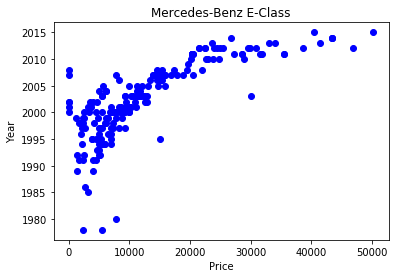

In [2]:
#Нарисуем зависимость цены от года выпуска для мерседеса E-Class
mercedes = data.query('car=="Mercedes-Benz"')
mercedes_eclass = data.query('car=="Mercedes-Benz" and model=="E-Class"')

def plot_data(x,y,marker='o', c=[0.,0.,1.],ax=None):
    if ax is None:
        mpl_fig = plt.figure()
        ax = mpl_fig.add_subplot(111)
    ax.set_title("Mercedes-Benz E-Class")
    ax.set_xlabel("Price")
    ax.set_ylabel("Year")
    ax.scatter(x,y,marker=marker,c=c)
    return ax

plot_data(mercedes_eclass['price'],mercedes_eclass['year'])

## DL 01.02 Линейная регрессия

Пусть $x$ - год выпуска, $y$ - цена

Мы хотим построить зависимость:
$y=f(x)$, чтобы для нового года выпуска предсказывать цену

Перавя наша модель будет линейной $y=ax+b$ где коэфциенты $a$ и $b$ нужно обучить

In [3]:
import torch

x = torch.from_numpy(mercedes_eclass['year'].as_matrix().astype(np.float32))
y = torch.from_numpy(mercedes_eclass['price'].as_matrix().astype(np.float32))


#Нормируем данные
x = (x-torch.mean(x))/torch.std(x)
y = (y-torch.mean(y))/torch.std(y)

#Запишем параметры модели
a = torch.FloatTensor([1.])
a.requires_grad=True # Выстатив данный флаг указывает pytorch, что для данной переменной необходимо вычислить градиенты
b = torch.FloatTensor([1.])
b.requires_grad=True


def h(x,a,b):
    return a*x+b

## DL 01.03 Функция потерь

В задаче линейной регрессии мы будем считать функцию потерь как среднеквадратичное отклонение:

$l_{a,b}(x,y)=\frac{1}{2*N}\sum(a*x_i+b-y_i)^2$

In [4]:
#Функция потерь
loss = torch.mean(torch.pow(h(x,a,b)-y,2))

In [5]:
mse = torch.nn.MSELoss()
mse(h(x,a,b),y).item()

1.4565856456756592

## DL 01.04 Градиентный спуск
Напишем процедуру оптимизации функции потерь методом градиентного спуска


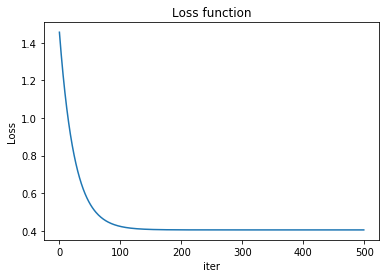

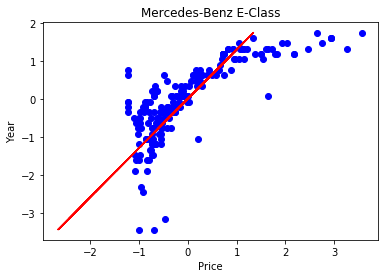

In [6]:
def plot_loss(errors):
    mpl_fig = plt.figure()
    ax = mpl_fig.add_subplot(111)
    ax.set_title("Loss function")
    ax.set_xlabel("iter")
    ax.set_ylabel("Loss")
    ax.plot(errors) 
    
errors = []

lr = 0.01 #Скорость обучения
with torch.no_grad():#Отключаем автоматическое вычисление градиентов pytorch
    a.fill_(1.)
    b.fill_(1.)
    for i in range(500):
        # Вычисляем производные по loss по параметрам a и b
        dlda = 2*torch.mean((a*x+b-y)*x)
        dldb = 2*torch.mean((a*x+b-y))
        #На самом деле вычисление функции потерь нужно для того чтобы 
        loss = torch.mean((a*x+b-y)**2)
        errors+=[loss.item()]
        #Шаг градиента
        a -= dlda*lr
        b -= dldb*lr
        
plot_loss(errors)
#Подставим получившиеся параметры в нашу модель
y_aprox = x*a+b
ax = plot_data(y,x)
ax.plot(y_aprox.detach().numpy(),x.numpy(),'r-')

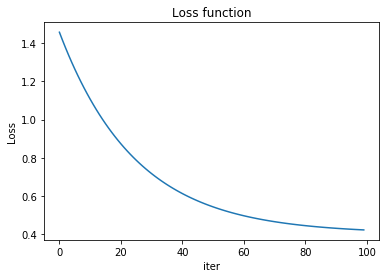

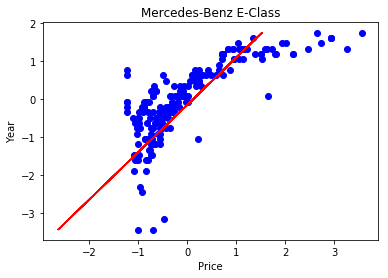

In [7]:
errors = []
with torch.no_grad():#Отключаем автоматическое вычисление градиентов pytorch для сброса параметров
    a.fill_(1.)
    b.fill_(1.)
lr = 0.01 #Скорость обучения
for i in range(100):
    #Обнулить градиенты
    if a.grad: a.grad.zero_() 
    if b.grad: b.grad.zero_() 
        
    loss = torch.mean((a*x+b-y)**2)#Вычислить значение функции потерь  
    loss.backward()#Вычислить градиенты по параметрам у ктороых стоит флаг requires_grad=True
    with torch.no_grad():#Отключаем автоматическое вычисление градиентов
        #Обновляем значения параметров модели
        a -= a.grad*lr
        b -= b.grad*lr
    errors+=[loss.item()]#Сохранить значение функции потерь

#Нарисовать функцию потерь
plot_loss(errors)
#Подставим получившиеся параметры в нашу модель
y_aprox = x*a+b
ax = plot_data(y,x)
ax.plot(y_aprox.detach().numpy(),x.numpy(),'r-')

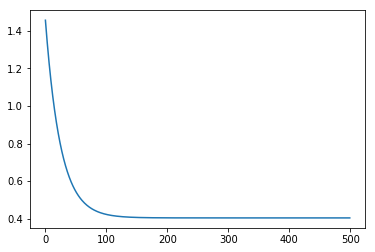

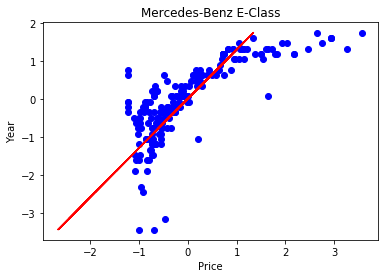

In [8]:

with torch.no_grad():#Отключаем автоматическое вычисление градиентов pytorch для сброса параметров
    a.fill_(1.)
    b.fill_(1.)
    
import torch.optim as optim
opt = optim.SGD(params=[a,b],lr=0.01)
errors = []

for i in range(500):
    opt.zero_grad()#Обнулить градиенты ОЧЕНЬ ВАЖНО!
    loss = torch.mean((a*x+b-y)**2)#Вычислить значение функции потерь  
    loss.backward()
    opt.step()
    errors+=[loss.item()]
    
    
plt.plot(errors)  
#Подставим получившиеся параметры в нашу модель
y_aprox = x*a+b
ax = plot_data(y,x)
ax.plot(y_aprox.detach().numpy(),x.numpy(),'r-')

Перепишем нашу модель в стиле PyTorch с использованием вместо явного задания функции модуль torch.nn.Linear

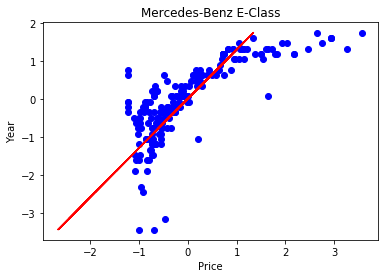

In [9]:
model = torch.nn.Linear(1,1)#Вместо a b используем класс линейного слоя нейронной сети
opt = optim.SGD(params=model.parameters(),lr=0.01)
vx = x.unsqueeze(-1)
vy = y.unsqueeze(-1)
for i in range(10000):
    loss = torch.nn.functional.mse_loss(model(vx),vy)
    loss.backward()
    opt.step()
    
y_aprox = x*a+b
ax = plot_data(y,x)
ax.plot(y_aprox.detach().numpy(),x.numpy(),'r-')

## DL 01.05 Многомерная линейная регрессия
Что если наша текущая модель не самая аддекватная? Мы можем попробовать использобать квадратичную модель: $y = w_01 + w_1x_1 + w_2x_1^2$

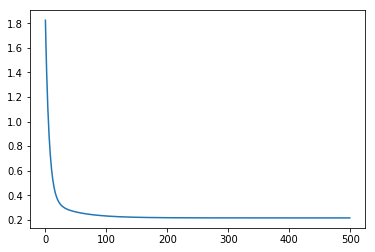

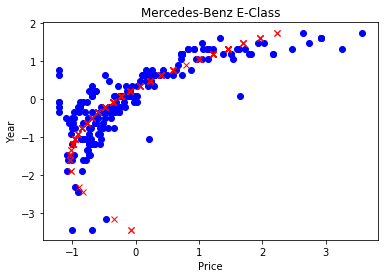

In [10]:
model = torch.nn.Linear(2,1)#Вместо a b используем класс линейного слоя нейронной сети
opt = optim.SGD(params=model.parameters(),lr=0.01)
vx = x.unsqueeze(-1)
vy = y.unsqueeze(-1)
vx2 = torch.cat([vx**2,vx],1)
errors=[]
for i in range(500):
    opt.zero_grad()
    loss = torch.nn.functional.mse_loss(model(vx2),vy)
    loss.backward()
    opt.step()
    errors+=[loss.item()]
    
    
plt.plot(errors)  
    
y_aprox = model(vx2)
ax = plot_data(y,x)
ax.plot(y_aprox.detach().numpy(),x.numpy(),'rx')

Пример неадекватной модели
$y=w_01+w_1x_1+w_2x_1^2+w_3x_1^3+w_4x_1^4$
Очевидно, что цена не будет падать у новых автомобилей.

torch.Size([199, 4])


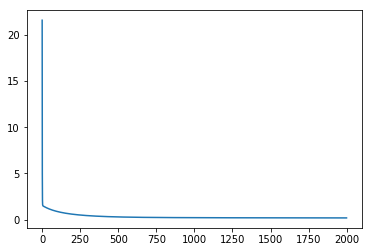

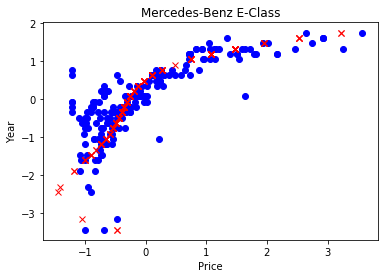

In [11]:
model = torch.nn.Linear(4,1)#Вместо a b используем класс линейного слоя нейронной сети
opt = optim.SGD(params=model.parameters(),lr=0.001)
vx = x.unsqueeze(-1)
vy = y.unsqueeze(-1)
vx2 = torch.cat([vx**4,vx**3,vx**2,vx],1)
print(vx2.shape)
errors=[]
for i in range(2000):
    opt.zero_grad()
    loss = torch.nn.functional.mse_loss(model(vx2),vy)
    loss.backward()
    opt.step()
    errors+=[loss.item()]
    
    
plt.plot(errors)  
    
y_aprox = model(vx2)
ax = plot_data(y,x)
ax.plot(y_aprox.detach().numpy(),x.numpy(),'rx')

Использование различных признаков

torch.Size([199, 2])
(Parameter containing:
tensor([[ 0.5694, -0.3394]]), Parameter containing:
tensor(1.00000e-06 *
       [ 4.1802]))
1.6029907465


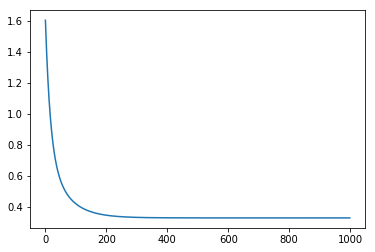

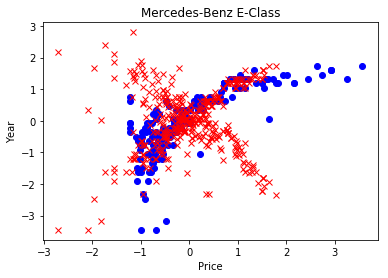

In [12]:
x = torch.from_numpy(mercedes_eclass.get(['year','mileage']).as_matrix().astype(np.float32))
meanx = torch.mean(x,dim=0)
stdx = torch.std(x,dim=0)
x = (x-meanx)/stdx
print(x.shape)

model = torch.nn.Linear(2,1)#Вместо a b используем класс линейного слоя нейронной сети
opt = optim.SGD(params=model.parameters(),lr=0.01)
vx = x
vy = y.unsqueeze(-1)

errors=[]
for i in range(1000):
    opt.zero_grad()
    loss = torch.nn.functional.mse_loss(model(vx),vy)
    loss.backward()
    opt.step()
    errors+=[loss.item()]

print(model.weight,model.bias)
    
plt.plot(errors) 
print(errors[0])
    
y_aprox = model(vx)
ax = plot_data(y,x[:,0])
ax.plot(y_aprox.detach().numpy(),x.numpy(),'rx')

# DL 01.06 Разбиение данных
Для оценки правильности работы нашего алгоритма разобъем данные на три группы: обучающая выборка (80%), валидационная выборка (10%) и тестовая выборка (10%)

* обучающая выборка (training set) на ней будем запускать алгоритм машинного обучения
* валидационная выборка (valid set) на ней будем настраивать параметры обучающего алгоритма и модели
* тестовая выборка (test set) выборка на которой мы измеряем точноть нашего метода 

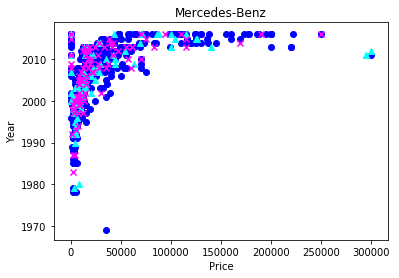

In [13]:
indexes = np.random.permutation(len(mercedes))
valid_len = test_len = len(mercedes)/10
train = mercedes.iloc[indexes[:-valid_len-test_len]]
valid = mercedes.iloc[indexes[-valid_len-test_len:-test_len]]
test = mercedes.iloc[indexes[-test_len:]]

ax = plot_data(train['price'],train['year'],marker='o', c=[0.,0.,1.])
plot_data(valid['price'],valid['year'],marker='^', c=[0.,1.,1.],ax=ax)
plot_data(test['price'],test['year'],marker='x', c=[1.,0.,1.],ax=ax)
ax.set_title("Mercedes-Benz")

## DL 01.06 Логистическая регрессия и классификация
Мы получаем пару год, цена и хотим ответить завышена цена автомобиля или нет

In [14]:
x = torch.from_numpy(train.get(['year','price']).as_matrix().astype(np.float32))
meanx = torch.mean(x,dim=0)
stdx = torch.std(x,dim=0)
x = (x-meanx)/stdx

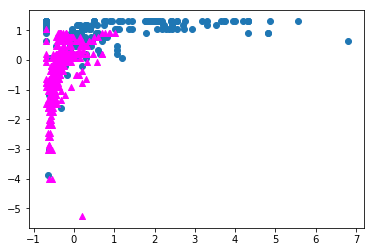

In [15]:
has_reg = np.where(train['mileage'].as_matrix().astype(np.float32)<100)
plt.scatter(x[has_reg,1],x[has_reg,0])
no_reg = np.where(train['mileage'].as_matrix().astype(np.float32) >=100)
plt.scatter(x[no_reg,1],x[no_reg,0],marker='^', c=[1.,0.,1.])

In [16]:
def sigmoid(x):
    return 1./(1.+np.exp(-x))

## DL 01.07 Функция потерь для логистической регрессии

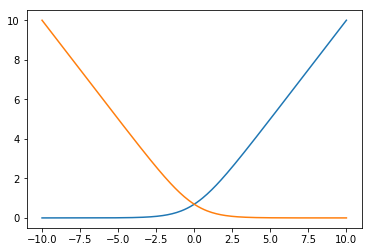

In [17]:
def bce(x,y):
    return -y*np.log(sigmoid(x))-(1-y)*np.log(1-sigmoid(x))

x = np.linspace(-10.,10.,200)
plt.plot(x,bce(x,0))
plt.plot(x,bce(x,1))

torch.Size([737, 2])


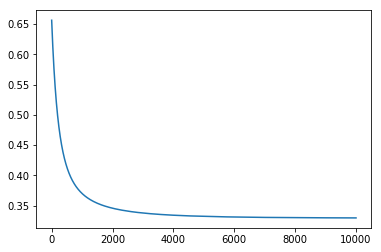

In [18]:
#Добавлем сигмоиду в нашу модель вычислений
model = torch.nn.Sequential(torch.nn.Linear(2,1),torch.nn.Sigmoid())


x = torch.from_numpy(train.get(['year','price']).as_matrix().astype(np.float32))
#Нормируем данные
meanx = torch.mean(x,dim=0)
stdx = torch.std(x,dim=0)
x = (x-meanx)/stdx

y = torch.from_numpy((train['mileage'].as_matrix().astype(np.float32)<100).astype(np.float32))


opt = optim.SGD(params=model.parameters(),lr=0.01)
print(x.shape)
vx = x
vy = y.unsqueeze(-1)
errors=[]
for i in range(10000):
    
    opt.zero_grad()
    v = model(vx)
    loss = torch.nn.functional.binary_cross_entropy(v,vy)
    loss.backward()
    opt.step()
    errors+=[loss.item()]
    
plt.plot(errors)  

In [19]:
valid_x = torch.from_numpy(valid.get(['year','price']).as_matrix().astype(np.float32))
valid_x = (valid_x-meanx)/stdx
y_aprox = model(valid_x)
y_true =torch.from_numpy((valid['mileage'].as_matrix().astype(np.float32)<100).astype(np.float32))

In [20]:
def confusion(prediction, truth):
    confusion_vector = prediction / truth

    true_positives = torch.sum(confusion_vector == 1).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_positives = torch.sum(confusion_vector == float('inf')).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives

print(confusion((y_aprox[:,0]>0.5).float(),y_true.float()))

(23, 2, 60, 7)


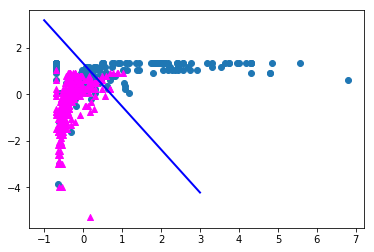

In [21]:
new_car = np.where(train['mileage'].as_matrix().astype(np.float32)<100)
plt.scatter(x[new_car,1],x[new_car,0])
not_new_car = np.where(train['mileage'].as_matrix().astype(np.float32) >=100)
plt.scatter(x[not_new_car,1],x[not_new_car,0],marker='^', c=[1.,0.,1.])

def get_x2(x1,w0,w1,w2):
    return -(w1*x1+w0)/w2

x1 = np.linspace(-1,3)
w0=model[0].bias.item()
w1 = model[0].weight[0,0].item()
w2 = model[0].weight[0,1].item()
plt.plot(x1, get_x2(x1,w0,w1,w2), color='b', linestyle='-', linewidth=2)

## DL 01.08 Мультиклассовая классификация

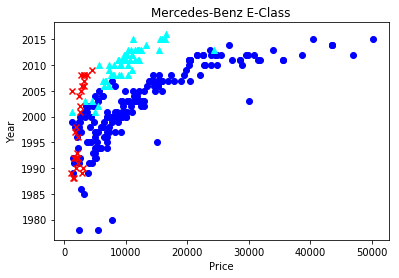

In [22]:
mercedes_eclass = data.query('car=="Mercedes-Benz" and model=="E-Class" and price>0 and engV !="NaN"')
ford_focus = data.query('car=="Ford" and model=="Focus" and price>0 and engV !="NaN"')
vaz_2109 = data.query('car=="VAZ" and model=="2109" and price>0 and engV !="NaN"')

ax = plot_data(mercedes_eclass['price'],mercedes_eclass['year'],marker='o', c=[0.,0.,1.])
plot_data(ford_focus['price'],ford_focus['year'],marker='^', c=[0.,1.,1.],ax=ax)
plot_data(vaz_2109['price'],vaz_2109['year'],marker='x', c=[1.,0.,0.],ax=ax)

In [23]:
all_data = pd.concat([mercedes_eclass,ford_focus,vaz_2109])
indexes = np.random.permutation(len(all_data))
valid_len = test_len = len(all_data)/10
train = all_data.iloc[indexes[:-valid_len-test_len]]
valid = all_data.iloc[indexes[-valid_len-test_len:-test_len]]
test = all_data.iloc[indexes[-test_len:]]

In [24]:
x = torch.from_numpy(train.get(['year','price','mileage','engV']).as_matrix().astype(np.float32))
#Нормируем данные
meanx = torch.mean(x,dim=0)
stdx = torch.std(x,dim=0)
x = (x-meanx)/stdx

#y = torch.from_numpy((train['mileage'].as_matrix().astype(np.float32)<100).astype(np.float32))

In [25]:
def one_hot(data,classes):
    onehot = np.zeros((len(data),len(classes)))
    for idx,car in enumerate(data['car']):
        x = classes.index(car)
        onehot[idx,x]=1
    return onehot

def cat(data,classes):
    cat_id = np.zeros((len(data)))
    for idx,car in enumerate(data['car']):
        cat_id[idx]=classes.index(car)
    return cat_id

cat(train,['Mercedes-Benz','VAZ','Ford'])

array([2., 1., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 2.,
       2., 0., 2., 0., 0., 0., 2., 0., 0., 1., 2., 0., 2., 2., 1., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 2., 2., 0., 0.,
       2., 0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 1., 2., 2., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 2., 0., 2.,
       2., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0.,
       0., 0., 2., 2., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 2., 1., 0.,
       2., 0., 1., 0., 2., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 2., 1., 0., 0., 2., 0., 0.,
       0., 2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 2., 0., 0., 0., 0., 1.,
       0., 2., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0.])

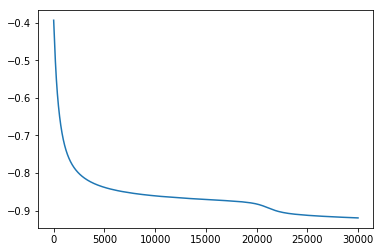

In [26]:
model = torch.nn.Sequential(torch.nn.Linear(4,3))
#model = torch.nn.Sequential(torch.nn.Linear(4,4),torch.nn.ReLU(),torch.nn.Linear(4,3))
opt = optim.SGD(params=model.parameters(),lr=0.01)

vx = x
y = torch.from_numpy(cat(train,['Mercedes-Benz','VAZ','Ford'])).long()
vy = y
errors=[]
for i in range(30000):
    
    opt.zero_grad()
    v = model(vx)
    v = torch.nn.functional.softmax(v,dim=1)
    loss = torch.nn.functional.nll_loss(v,vy)
    loss.backward()
    opt.step()
    errors+=[loss.item()]
    
plt.plot(errors)  

In [27]:
import torch
model = torch.nn.Sequential(torch.nn.Linear(4,3))
cce = torch.nn.CrossEntropyLoss()
opt = optim.SGD(params=model.parameters(),lr=0.01)

vx = x
y = torch.from_numpy(cat(train,['Mercedes-Benz','VAZ','Ford'])).long()
vy = y
errors=[]
for i in range(30000):
    
    opt.zero_grad()
    v = model(vx)
    loss = cce(v,vy)
    loss.backward()
    opt.step()
    errors+=[loss.item()]

In [28]:
valid_x = torch.from_numpy(valid.get(['year','price','mileage','engV']).as_matrix().astype(np.float32))
#Нормируем данные
valid_x = (valid_x-meanx)/stdx

In [29]:
probs = model(valid_x)
print(np.argmax(probs.detach(),axis=1))
print(cat(valid,['Mercedes-Benz','VAZ','Ford']))
print(np.sum(np.argmax(probs.detach(),axis=1).numpy()==cat(valid,['Mercedes-Benz','VAZ','Ford']))/float(len(valid_x)))

tensor([ 0,  0,  0,  0,  2,  0,  0,  2,  0,  0,  0,  2,  0,  0,
         0,  2,  0,  0,  0,  0,  0,  2,  0,  0,  1,  0,  0])
[0. 0. 0. 0. 2. 0. 0. 2. 0. 0. 0. 2. 0. 0. 0. 2. 0. 0. 0. 0. 0. 2. 2. 0.
 1. 0. 0.]
0.9629629629629629


## DL 01.09 Граф вычислений

In [32]:
import torchvision
import torch.nn as nn

mnist = torchvision.datasets.MNIST('/home/vkulikov',download=True)
#convert images into vectors 60000x784
x = mnist.train_data.reshape(mnist.train_data.shape[0],-1).float()
y = mnist.train_labels.long()

In [33]:
seq_model = nn.Sequential(nn.Linear(784,128),nn.ReLU(),nn.Linear(128,10))

In [34]:
import torch.optim as optim
cce = torch.nn.CrossEntropyLoss()
opt = optim.SGD(params=seq_model.parameters(),lr=0.001)

errors=[]
for i in range(100):  
    opt.zero_grad()
    v = seq_model(x)
    loss = cce(v,y)
    loss.backward()
    opt.step()
    errors+=[loss.item()]

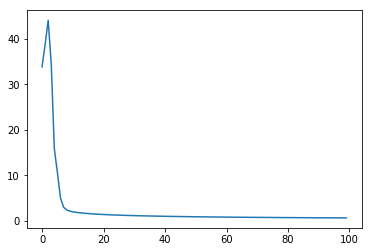

In [35]:
plt.plot(errors)

In [38]:
valid_mnist = torchvision.datasets.MNIST('/home/vkulikov',train=False,download=True)
vx = valid_mnist.test_data.reshape(valid_mnist.test_data.shape[0],-1).float()
predicted = seq_model(vx)
torch.sum(np.argmax(predicted.detach(),1)==valid_mnist.test_labels).float()/vx.shape[0]

tensor(0.8434)

## DL 01.10 Метод обратного распространения ошибки

In [39]:
import torch.nn as nn


class Network(nn.Module):
    def __init__(self, in_par=784, out_par=10):
        super(Network, self).__init__()
        self.linear_module_1 = nn.Linear(in_par, 128)
        self.relu = nn.ReLU()
        self.linear_module_2 = nn.Linear(128, out_par)

    def forward(self, x):
        x = self.linear_module_1(x)
        x = self.relu(x)
        return self.linear_module_2(x)


seq_model = Network(784)

## DL 01.11 Стохастическая оптимизация

In [40]:
import torch.optim as optim
seq_model = nn.Sequential(nn.Linear(784,128),nn.ReLU(),nn.Linear(128,10))
cce = torch.nn.CrossEntropyLoss()
opt = optim.SGD(params=seq_model.parameters(),lr=0.0001)

errors=[]
for i in range(1000):  
    opt.zero_grad()
    indexes = torch.randint(high=x.shape[0],size=(1,10)).long()
    vx,vy = x[indexes[0]],y[indexes[0]]
    v = seq_model(vx)
    loss = cce(v,vy)
    loss.backward()
    opt.step()
    errors+=[loss.item()]

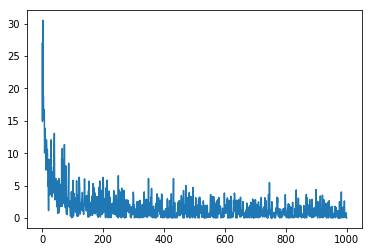

In [41]:
plt.plot(errors)

In [42]:
import torch.optim as optim
from torchvision import transforms
mnist = torchvision.datasets.MNIST('/home/vkulikov',transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ]), train=True,download=True)

train_loader = torch.utils.data.DataLoader(mnist,batch_size=100,shuffle=True)

seq_model = nn.Sequential(nn.Linear(784,128),nn.ReLU(),nn.Linear(128,10))
cce = torch.nn.CrossEntropyLoss()
opt = optim.SGD(params=seq_model.parameters(),lr=0.001,momentum=0.0)

errors=[]
nepoch = 5

for e in range(nepoch):
    for vx,vy in train_loader:
        opt.zero_grad()
        v = seq_model(vx.view(vx.shape[0],-1))
        loss = cce(v,vy)
        loss.backward()
        opt.step()
        errors+=[loss.item()]    

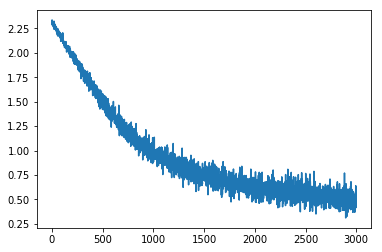

In [43]:
plt.plot(errors)

In [44]:
valid_mnist = torchvision.datasets.MNIST('/home/vkulikov',transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ]), train=False,download=True)
vx = valid_mnist.test_data.reshape(valid_mnist.test_data.shape[0],-1).float()
predicted = seq_model(vx)
torch.sum(np.argmax(predicted.detach(),1)==valid_mnist.test_labels).float()/vx.shape[0]

tensor(0.8349)

## DL 01.12 Переобучение и регуляризация

In [45]:
import torch.optim as optim
from torchvision import transforms
mnist = torchvision.datasets.MNIST('/home/vkulikov',transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ]), train=True,download=True)

train_loader = torch.utils.data.DataLoader(mnist,batch_size=10,shuffle=True)

device = "cuda"
seq_model = nn.Sequential(nn.Linear(784,512),
                          nn.Dropout(0.2),
                          nn.ReLU(),
                          nn.Linear(512,256),
                          nn.Dropout(0.2),
                          nn.ReLU(),
                          nn.Linear(256,128),
                          nn.ReLU(),
                          nn.Linear(128,10)).to(device)

cce = torch.nn.CrossEntropyLoss()
opt = optim.SGD(params=seq_model.parameters(),lr=0.001,momentum=0.01)

errors=[]
nepoch = 20

for e in range(nepoch):
    for vx,vy in train_loader:
        vx = vx.to(device)
        vy = vy.to(device)
        opt.zero_grad()
        v = seq_model(vx.view(vx.shape[0],-1))
        loss = cce(v,vy)
        loss.backward()
        opt.step()
        errors+=[loss.item()]    


In [46]:
valid_mnist = torchvision.datasets.MNIST('/home/vkulikov',transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ]), train=False,download=True)
vx = valid_mnist.test_data.reshape(valid_mnist.test_data.shape[0],-1).float().to(device)
seq_model.eval()
predicted = seq_model(vx)
torch.sum(np.argmax(predicted.detach(),1)==valid_mnist.test_labels).float()/vx.shape[0]

tensor(0.9666)

## DL 01.13 Заключение

In [47]:
import torch.optim as optim
from torchvision import transforms
mnist = torchvision.datasets.MNIST('/home/vkulikov',transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ]), train=True,download=True)

train_loader = torch.utils.data.DataLoader(mnist,batch_size=10,shuffle=True)

device = "cuda"
seq_model = nn.Sequential(nn.Linear(784,512),
                          nn.Dropout(0.2),
                          nn.ReLU(),
                          nn.Linear(512,256),
                          nn.Dropout(0.2),
                          nn.ReLU(),
                          nn.Linear(256,128),
                          nn.ReLU(),
                          nn.Linear(128,10)).to(device)

cce = torch.nn.CrossEntropyLoss()
opt = optim.Adam(params=seq_model.parameters(),lr=0.001)

errors=[]
nepoch = 10

for e in range(nepoch):
    for vx,vy in train_loader:
        vx = vx.to(device)
        vy = vy.to(device)
        opt.zero_grad()
        v = seq_model(vx.view(vx.shape[0],-1))
        loss = cce(v,vy)
        loss.backward()
        opt.step()
        errors+=[loss.item()]    

In [48]:
valid_mnist = torchvision.datasets.MNIST('/home/vkulikov',transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ]), train=False,download=True)
vx = valid_mnist.test_data.reshape(valid_mnist.test_data.shape[0],-1).float().to(device)
seq_model.eval()
predicted = seq_model(vx)
torch.sum(np.argmax(predicted.detach(),1)==valid_mnist.test_labels).float()/vx.shape[0]

tensor(0.9403)